# Change Detection - Image Ratio Thresholding
### Summary
This notebook detects change between satellite images taken at subsequent times over the same location by calculating the ratio of pixel values and applying a thresholding window within which change is identified. It was calibrated on [Sentinel-2](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/overview) pre-post disaster imagery from the Caribbean and [Copernicus EMS](https://emergency.copernicus.eu/mapping/map-of-activations-rapid#zoom=3&lat=29.18235&lon=-70.57787&layers=BT00) damage data and built using the Descartes Labs platform. Sections 3 & 4 allow you to evaluate the detection against reported damages.
### Contents
- 1 - [Visualise Imagery](#visualiseImagery)
- 2 - [Change Detection](#changeDetection)
- 3 - [Evaluate Model Detections](#evaluate)
- 4 - [Quantify Model Accuracy](#quantify)

### Requirements
- Lat/Long coordinates for your desired location
- Geojson of ocean for masking in coastal locations

### Possible improvements
- Faster implementation of accuracy assessment
- Google Colab compatibility checks
____________
## Initialisation - Define variables & import packages

In [1]:
# Location
location = 'HaitiJeremie' # Name for saved .pngs
lat, lon = 18.6421, -74.1167 # Center of Area of Interest 
zoom = 15 # Map tile zoom, 16 default

# Imagery properties
st_date, end_date = ['2016-07-01', '2016-10-06'], ['2016-09-30', '2016-11-06'] # Timeframes for before-after imagery: start 1, start 2; end 1 ,end 2
satellite = "sentinel-2:L1C" # Descartes product name
visual = ['red','green','blue'] # Imagery bands for display purposes
cloudFraction = 0.8 # May need adjusted to get images from appropriate dates for Sentinel

# Ratio properties
bands = ['red'] # Bands used to evaluate ratio
threshold, cap =  0.01, 0.1 # Initial bounds for logarithmic ratio change detection
kSize = 1 # Pixel dilatation kernel size

# Damage grading for evaluation
dmgAssess = "gradings/EMSR185_11JEREMIE_02GRADING_MONIT01_v1_4000_settlements_point_grading.dbf" # Damage assessment database location (.dbf file needs .prj,.shp,.shx in same directory)
grades = ['Completely Destroyed','Highly Damaged','Moderately Damaged'] # Options: 'Not Applicable','Negligible to slight damage', 'Moderately Damaged', 'Highly Damaged', 'Completely Destroyed'
area = 0.0004 # Building polygon size in lat/long degrees
dmgFile = 'geojsons/'+location+'Damage'+str(area)[2:]+'g'+str(len(grades))+'.geojson' # Damage file name qualifying location and area size
maskPoly = 'coastlines/swHaitiCoastline.geojson' # Geojson file masking feature such as ocean

In [2]:
# Import packages
# Python libraries
import numpy as np
import random
import os
import IPython
import ipywidgets
import ipyleaflet
import json
import geopandas as gpd
import pandas as pd
import geojson
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Python library functions
from shapely.geometry import Polygon, Point
from tqdm import tqdm
from ipyleaflet import Map, GeoJSON, GeoData, LegendControl
from ipywidgets import FloatRangeSlider

# Descartes Labs
import descarteslabs as dl
import descarteslabs.workflows as wf
from descarteslabs.vectors import FeatureCollection, properties as p
from descarteslabs.workflows import GeoContext, Feature, FeatureCollection

# Custom functions
from unet import UNet

_____________
<a id='visualiseImagery'></a>
## 1 - Visualise Imagery
We'll start by displaying before and after images for chosen location. Two pointers here:
- You'll need to click the magic markers below the map to scale the imagery band colours properly. 
- If no imagery appears for your location, try increasing the cloud fraction, but check this does not lead to overly cloudy images which may affect detection performance. Alternatively try changing or widening the requested dates, it is not uncommon to span several months for a good image.

In [3]:
# Initialise map
m1 = wf.interactive.MapApp()
m1.center, m1.zoom = (lat, lon), zoom

# Define function which retrieves imagery for specified time period and band. Allow specification of layer opacity and map number
def getImage(time,bands,opacity=1,mapNum=m1):
    img = wf.ImageCollection.from_id(satellite,start_datetime=st_date[time], end_datetime=end_date[time])
    if 'sentinel' in satellite: # Use sentinel cloud-mask band if available
        img = img.filter(lambda img: img.properties["cloud_fraction"] <= cloudFraction)
        img = img.map(lambda img: img.mask(img.pick_bands('cloud-mask')==1))
    mos = (img.mosaic().pick_bands(bands))
    globals()['mos_'+str(time+1)+str(bands)] = mos
    display = mos.visualize('Image '+str(time+1)+' '+str(bands), map=mapNum)
    display.opacity = opacity

# Loop over dates (time 1 & ime 2)
for i in range(len(st_date)):
    for j in bands: getImage(i,j,0,m1 ) # Retrieve layer for each band to be used for ratio
    getImage(i,visual,1,m1) # Retrieve layer for visual

m1


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


________
<a id='detectChange'></a>
## 2 - Detect Change
Next, let's take the logarithmic ratio of images for selected bands and display detected change superimposed on the image for time 2. Beneath the plot is a slider allowing you to vary the thresholds within which we are detecting change. 

> The optimal threshold interval for detecting building change has been determined as 0.01-0.1. However, due to differences in lighting between repeat images this may need adjsuted according to location. As the ratio is logarithmic, if the second image is considerably darker than the first, the appropriate thresholding may even be negative.

Detection interval equation for RGB where r1 denotes pixel value for red band at time 1:  $ threshold < \log\left(\frac{r2}{r1} \times \frac{b2}{b1} \times \frac{g2}{g1}\right) < cap  $

In [4]:
# Build logarithmic ratio adding together values from each band
for i in bands: 
    globals()['log_ratio'+i] = wf.log10(globals()['mos_1'+i] / globals()['mos_2'+i]) # Ratio for band
    log_ratio = globals()['log_ratio'+i] if (i is bands[0]) else log_ratio + globals()['log_ratio'+i] # log(a)+log(b) = log(axb)

# Define erosion and dilation functions for convolving kernel through ratio
def erode_op(map_layer, iters, kernel):
    map_layer = ~map_layer
    for i in range(iters):
        map_layer = wf.conv2d(map_layer, kernel) > 0
    map_layer = ~map_layer 
    return map_layer

def dilate_op(map_layer, iters, kernel):
    for i in range(iters):
        map_layer = map_layer * 1.0
        map_layer = wf.conv2d(map_layer, kernel) > 0
    return map_layer

# Define a kernel and perform one erosion followed by two dilations
kernel = wf.Kernel(dims=(kSize,kSize), data=np.ones([1,kSize**2]).tolist()[0])
#     dims=(3,3), data=[0.,1.,0.,1.,1.,1.,0.,1.,0.,]) # for cross shaped kernel

# Create map with before/after images upon which to superimpose detected change
m2 = wf.map.map
m2.center, m2.zoom = (lat, lon), zoom
before, after, ratio = globals()['mos_1'+str(visual)].visualize('Before', map=m2), globals()['mos_2'+str(visual)].visualize('After', map=m2), log_ratio.visualize('Ratio',colormap='plasma' , map=m2)
before.opacity, after.opacity, ratio.opacity = 0,0.7,0
display(ipywidgets.HBox([wf.map]))

# Create slider to adjust ratio bounds
slider = FloatRangeSlider(value=[threshold, cap], min=-0.5, max=0.5, step=0.01, description='Filter ratios', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.2f')
display(slider)
print('Run box below to display updated detection result')

# Define function for plotting detected change
def plotChange(slider, log_ratio, maskPoly, kernel):
    # Detect change according to bounds for logarithmic ratio
    change = (slider.value[0] < log_ratio) & (log_ratio < slider.value[1])

    # Apply dilatation to change
    eroded = erode_op(change, iters=1, kernel=kernel)
    dilated = dilate_op(eroded, iters=2, kernel=kernel)

    # Visualize detections and apply mask for ocean or clouds
    if os.path.exists(maskPoly):
        omit = gpd.read_file(maskPoly) # Load coatlines
        omitMask = Feature(geometry=omit.geometry[0],properties={}).rasterize(value=1) # Mask sea
        detection = dilated.mask(dilated==0).mask(omitMask==1).visualize('Detected Change', checkerboard=False, colormap='plasma', map=m2)
    else: detection = dilated.mask(dilated==0).visualize('Detected Change', checkerboard=False, colormap='plasma', map=m2)
    detection.opacity = 0.7
    return dilated, omitMask

# Plot detected change
detections, omitMask = plotChange(slider, log_ratio, maskPoly, kernel)

if not 'l2' in globals(): # Add legend if forming map for first time
    l2 = LegendControl({"Detected Change":"#FFFF00"})
    m2.add_control(l2) 

`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jup…

FloatRangeSlider(value=(0.01, 0.1), description='Filter ratios', max=0.5, min=-0.5, step=0.01)

Run box below to display updated detection result


In [5]:
# Re-plot detected change according to slider values
detections, omitMask = plotChange(slider, log_ratio, maskPoly, kernel)

__________
<a id='evaluate'></a>
## 3 - Evaluate Detection Model
We can now use Copernicus EMS post-disaster damage assessments to evaluate our model's performance at detecting building change. Firstly we will extract a geolocalised array from the damage detection mask and then plot this against known damages.

In [6]:
# Convert mask into coordinate array
# Get vector of pixels which have changed coordinates
gtx, detection = wf.map.geocontext(), detections.mask(detections==0).mask(omitMask==1) if os.path.exists(maskPoly) else detections.mask(detections==0)
change = detection.compute(geoctx=gtx)

# Get latitude & longitude of each pixel in mask (whether true or false)
bounds = change.geocontext['bounds']
lats, longs = np.linspace(bounds[3],bounds[1],change.geocontext['arr_shape'][0]), np.linspace(bounds[0],bounds[2],change.geocontext['arr_shape'][1])

# Create matrix of coordinates for pixels with change detected
xm, ym = np.meshgrid(longs,lats)
xc, yc = xm*(1-change.ndarray.mask[0]), ym*(1-change.ndarray.mask[0])

# Get geodataframe for pixel points
df = pd.DataFrame(columns=['Latitude', 'Longitude'])
for i,j in tqdm(zip(np.nonzero(xc)[0], np.nonzero(xc)[1])):
    df = df.append({'Latitude': yc[i][j],'Longitude': xc[i][j]}, ignore_index=True)
    
det = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))


Job ID: 6836d7a05d1b0bb55992dfc01c8610eb5469acb799d0d3b3
[######] | Steps: 65/65 | Stage: SUCCEEDED                                    

4673it [00:07, 608.44it/s]


In [7]:
# Load in damage geojson from Copernicus EMS data
try: 
    settlements = gpd.read_file(dmgAssess).to_crs({'init': 'epsg:4326'})
    color_dict = {'Not Applicable':'green','Negligible to slight damage':'blue', 'Moderately Damaged':'yellow', 'Highly Damaged':'orange', 'Completely Destroyed':'red'}

    # Filter settlements to be within specified damage grade and location polygon
    damage = settlements[settlements.grading.isin(grades)]
    damage = damage[damage.within(Polygon(change.geocontext['geometry']['coordinates'][0]))]

    # Filter detections to area covered by damage inspection
    try: det = det.loc[(det.geometry.x < max(damage.geometry.x)) & (det.geometry.x > min(damage.geometry.x)) & (det.geometry.y < max(damage.geometry.y)) & (det.geometry.y > min(damage.geometry.y))]
    except: pass
except: print("No damage file set for this area. All further steps are for assessing detection against a damage assessment")


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


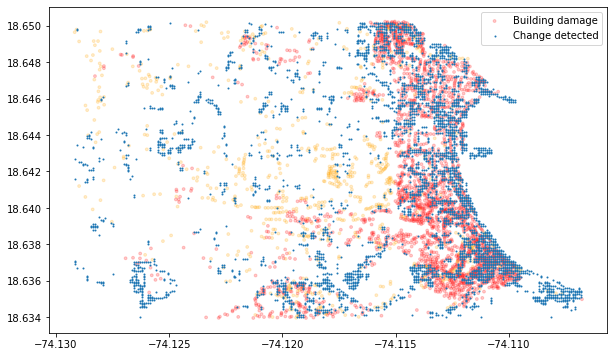

In [8]:
# Plot detected vs damaged in matplotlib
# Plot damages
try: # For assessments with damage points
    plt.figure(figsize=(10,6))
    plt.scatter(damage.geometry.x,damage.geometry.y,color=[color_dict[i] for i in damage.grading],s=8,alpha=0.2,label='Building damage')
except:  # For assessments with damage polygons
    try: plt = damage.plot(figsize=(10,6),column='grading',alpha=1.,legend=True,cmap='RdYlGn')
    except: print('As previously mentioned => No damage file to plot')
        
# Plot detections
plt.scatter(det.geometry.x,det.geometry.y,s=1, label='Change detected')
plt.legend()

# Display detected and damages on interactive map
# Initialise map
m3 = wf.interactive.MapApp()
m3.center, m3.zoom = (lat, lon), zoom

# Plot background image and overlay damages
after = globals()['mos_2'+str(visual)].visualize('After', map=m3)  
geo_data = GeoData(geo_dataframe = damage, style={'color': 'red', 'radius':2, 'fillColor': 'red', 'opacity':0.2, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.2},
                    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                    point_style={'radius': 3, 'color': 'red', 'fillOpacity': 0.2, 'fillColor': 'red', 'weight': 3},
                    name = 'Damages')
m3.add_layer(geo_data)

# Plot detections
try: detection = detections.mask(detections==0).mask(omitMask==1).visualize('Detected Change', checkerboard=False, colormap='plasma', map=m3)
except: detection = detections.mask(detections==0).visualize('Detected Change', checkerboard=False, colormap='plasma', map=m3)
detection.opacity, after.opacity = 0.7, 0.6

# Legend
m3.add_control(LegendControl({"Detected Change":"#FFFF00", "Recorded Damage":"#FF0000"})) 

m3

________
<a id='quantify'></a>
## 4 - Quantify Accuracy
After qualitatively assessing the ratio method's performance in the previous section, we will now quantify the accuracy of the method for detecting building damage. 

For this we first define a building footprint around the recorded damage point location. We then determine the accuracy with which detected changed pixels correspond to these building footprints. The metrics are as follows:
- Precision (proportion of damage detected): $P = \frac{True Positives}{True Positives + False Positives}$
- Recall (proportion of detections corresponding to damage): $R = \frac{True Positives}{True Positives + False Negatives}$
- F1 Score: $F1 = 2x\frac{P*R}{P+R}$

In [9]:
# Create polygons around point locations of damages
if not os.path.exists(dmgFile) and damage.geometry[damage.index[0]].type is not 'Polygon': # Gets point assessment damages into geojson file
    features = []
    for i in tqdm(damage.index):
        poly = Polygon([[damage.geometry.x[i], damage.geometry.y[i]], [damage.geometry.x[i]+area, damage.geometry.y[i]], [damage.geometry.x[i]+area, damage.geometry.y[i]+area], [damage.geometry.x[i], damage.geometry.y[i]+area], [damage.geometry.x[i], damage.geometry.y[i]]])
        features.append(geojson.Feature(properties={"Damage": damage.grading[i]}, geometry=poly))

    fc = geojson.FeatureCollection(features)
    with open(dmgFile, 'w') as f: geojson.dump(fc, f)
    
elif not os.path.exists(dmgFile):  # Puts polygon assessments into geojson file
    with open(dmgFile, 'w') as f: geojson.dump(damage, f)

In [10]:
# Load building damages
dmg = gpd.read_file(dmgFile)
print('Changed pixels:',len(det), '\nDamaged buildings:',len(dmg))

# Initialise accuracy and recall vectors
acc, rec = np.zeros([max(dmg.index)+1,1]), np.zeros([max(det.index)+1,1]) # Initialise accuracy, recall arrays

# Loop through pixels to determine recall (if pixel corresponds to damaged building)
for i in tqdm(det.index):
    # Loop through building to determine accuracy (damaged building has been detected)
    for j in dmg.index:
        if det.geometry[i].within(dmg.geometry[j]):
            rec[i,0], acc[j,0] = True, True

# Calculate metrics from vector outputs
a = sum(acc)/len(dmg)
r = sum(rec)/len(det)
f1 = 2*(a*r)/(a+r)
print('Precision:',a[0],'\nRecall:',r[0],'\nF1 score:',f1[0])

  0%|          | 1/4160 [00:00<11:58,  5.79it/s]

Changed pixels: 4160 
Damaged buildings: 3297


100%|██████████| 4160/4160 [13:36<00:00,  5.10it/s]

Precision: 0.7813163481953291 
Recall: 0.7069711538461538 
F1 score: 0.7422868490729542



`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


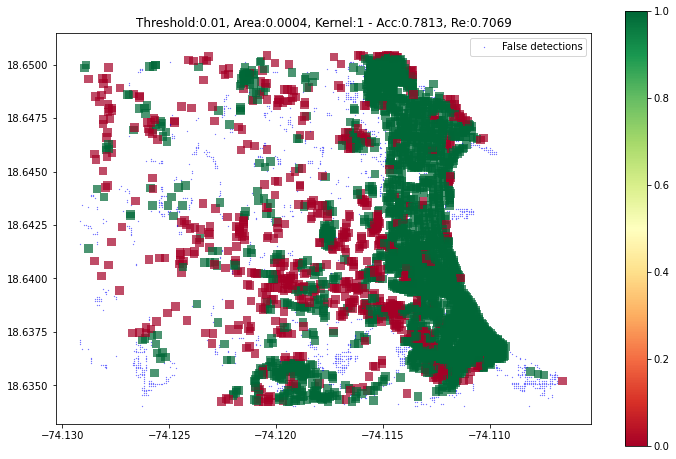

In [11]:
## Plot success of change detection in matplotlib and save figure
# Damage detected true/false
dmg['found'] = pd.Series(acc[:,0], index=dmg.index)
plt = dmg.plot(figsize=(12,8), column='found',legend=True,cmap='RdYlGn',alpha = 0.7)

# False detection points
points = np.vstack([rec[i] for i in det.index])
x1, y1 = np.array(det.geometry.x)*(1-points).transpose(), np.array(det.geometry.y)*(1-points).transpose()
x1, y1 = x1[x1 != 0], y1[y1 != 0]
plt.scatter(x1,y1,s=0.05,color='b', label='False detections')

# Set titles and save
plt.set_title('Threshold:'+str(threshold)+', Area:'+str(area)+', Kernel:'+str(kSize)+' - Acc:'+str(a[0])[:6]+', Re:'+str(r[0])[:6])
plt.legend()
plt.figure.savefig('results/'+location+'_t'+str(threshold)[2:]+'a'+str(area)[2:]+'g'+str(len(grades))+str(bands)+'.png')

## Display on interactive map
# Initialise map
m4 = wf.interactive.MapApp()
m4.center, m4.zoom = (lat, lon), zoom

# Plot background imagery as image 2 using function from map 1
getImage(1,visual,0.7,m4)

# Add layers for building polygons whether red for not found, green for found
not_found = GeoData(geo_dataframe = dmg.loc[dmg['found']==0], style={'color': 'red', 'radius':2, 'fillColor': 'red', 'opacity':0.7, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.7},
                    hover_style={'fillColor': 'red' , 'fillOpacity': 0.5},
                    name = 'Damages')
found = GeoData(geo_dataframe = dmg.loc[dmg['found']==1], style={'color': 'green', 'radius':2, 'fillColor': 'green', 'opacity':0.7, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.7},
                    hover_style={'fillColor': 'green' , 'fillOpacity': 0.5},
                    name = 'Damages')
m4.add_layer(not_found)
m4.add_layer(found)

# Plot pixels where change has been detected
try: detection = detections.mask(detections==0).mask(omitMask==1).visualize('Detected Change', checkerboard=False, colormap='plasma', map=m4)
except: detection = detections.mask(detections==0).visualize('Detected Change', checkerboard=False, colormap='plasma', map=m4)
detection.opacity = 0.7

# Legend
m4.add_control(LegendControl({"Detected Change":"#FFFF00", "Damage Identified":"#008000", "Damage Not Identified":"#FF0000"})) 

m4

# --------------- END ------------------------